# Analyse d'un relevé de comptes

## Import

In [259]:
import pandas as pd
import numpy as np
df = pd.read_csv("operations.csv")

## 1. Structure

In [260]:
df.shape

(309, 5)

In [261]:
df.head()

,date_operation,libelle,montant,solde_avt_ope,categ
0,2023-03-31,DON XX XX XX XX XX XX XX,-1.44,1515.25,AUTRE
1,2023-04-03,CARTE XX XX RAPT XX,-24.00,1513.81,TRANSPORT
2,2023-04-03,CARTE XX XX RAPT XX,-73.00,1489.81,TRANSPORT
3,2023-04-03,VIREMENT XX XX XX XX XX XX XX XX XX XX XX XX,676.00,1416.81,AUTRE
4,2023-04-03,VIREMENT XX XX XX XX XX XX,4.80,2092.81,AUTRE


In [262]:
df.dtypes

date_operation     object
libelle            object
montant           float64
solde_avt_ope     float64
categ              object
dtype: object

## 2. Ajustement des types

In [263]:
df['date_operation'] = pd.to_datetime(df['date_operation'])

In [264]:
df.dtypes

date_operation    datetime64[ns]
libelle                   object
montant                  float64
solde_avt_ope            float64
categ                     object
dtype: object

## 3. Recherche des valeurs manquantes

In [265]:
df.isnull().sum()

date_operation    0
libelle           0
montant           2
solde_avt_ope     0
categ             1
dtype: int64

### 3.1 Montants nulls

In [266]:
montants_nulls = df.loc[df['montant'].isnull(), :]

In [267]:
montants_nulls

,date_operation,libelle,montant,solde_avt_ope,categ
107,2023-06-12,CARTE XX XX LES ANCIENS ROBINSON XX,NaN,4667.19,COURSES
269,2023-09-11,CARTE XX XX XX XX,NaN,3401.93,AUTRE


In [268]:
montants_nulls.index

Int64Index([107, 269], dtype='int64')

In [269]:
for index in montants_nulls.index:
    df.loc[index, 'montant'] = np.round(df.loc[index+1, 'solde_avt_ope'] - df.loc[index, 'solde_avt_ope'], 2)
    nouveau_montant = df.loc[index, 'montant']
    print(f'Nouveau montant index {index}: {nouveau_montant}')


Nouveau montant index 107: -26.58
Nouveau montant index 269: -12.0


### 3.2 Category manquante

In [270]:
categories_null = df.loc[df['categ'].isnull(), 'categ']
categories_null

156    NaN
Name: categ, dtype: object

In [271]:
same_categ = df.loc[df['libelle'].str.contains("TELEPHONE") & df['categ'].notnull(), 'categ'].iloc[0]
df.loc[df['categ'].isnull(), 'categ'] = same_categ

### 3.3 Vérification plus de valeur null

In [272]:
df.isnull().sum().loc[lambda x : x > 0]

Series([], dtype: int64)

## 4. Doublons

In [273]:
df.loc[df[['date_operation', 'libelle', 'montant', 'solde_avt_ope']].duplicated(keep=False), :]

,date_operation,libelle,montant,solde_avt_ope,categ
43,2023-04-25,CARTE XX XX LES ANCIENS ROBINSON XX,-32.67,3647.67,COURSES
44,2023-04-25,CARTE XX XX LES ANCIENS ROBINSON XX,-32.67,3647.67,COURSES


In [274]:
df.drop_duplicates(subset=['date_operation', 'libelle', 'montant', 'solde_avt_ope'], keep='last', inplace=True)

Vérification

In [275]:
df.loc[df[['date_operation', 'libelle', 'montant', 'solde_avt_ope']].duplicated(keep=False), :]

,date_operation,libelle,montant,solde_avt_ope,categ


## 5. Valeurs abbérantes

In [276]:
df.describe()

,montant,solde_avt_ope
count,308.000000,308.000000
mean,-45.782013,3395.301071
std,872.818105,667.109412
min,-15000.000000,1416.810000
25%,-20.447500,3010.737500
50%,-9.600000,3452.465000
75%,-2.715000,3787.232500
max,1071.600000,4709.310000


In [277]:
df.loc[np.abs(df['montant']) > 10000]

,date_operation,libelle,montant,solde_avt_ope,categ
199,2023-08-03,CARTE XX XX XX XX,-15000.0,3797.35,AUTRE


In [278]:
df.loc[198:200, :]

,date_operation,libelle,montant,solde_avt_ope,categ
198,2023-08-03,VIREMENT XX XX XX XX XX XX XX XX XX XX XX XX,676.00,3121.35,AUTRE
199,2023-08-03,CARTE XX XX XX XX,-15000.00,3797.35,AUTRE
200,2023-08-03,CARTE XX XX L'EPICERIE DEMBAS XX XX,-10.51,3782.96,AUTRE


In [279]:
index = df.loc[np.abs(df['montant']) > 10000].index[0]
df.loc[index, 'montant'] = df.loc[index+1, 'solde_avt_ope'] - df.loc[index, 'solde_avt_ope']

Vérification

In [280]:
df.loc[np.abs(df['montant']) > 10000]

,date_operation,libelle,montant,solde_avt_ope,categ


In [281]:
df.isnull().sum()

date_operation    0
libelle           0
montant           0
solde_avt_ope     0
categ             0
dtype: int64

## 6. Représentations graphiques

### Catégories

In [282]:
df.dtypes

date_operation    datetime64[ns]
libelle                   object
montant                  float64
solde_avt_ope            float64
categ                     object
dtype: object

In [283]:
df['categ'] = df['categ'].astype('category')

In [284]:
df.dtypes

date_operation    datetime64[ns]
libelle                   object
montant                  float64
solde_avt_ope            float64
categ                   category
dtype: object

<AxesSubplot:>

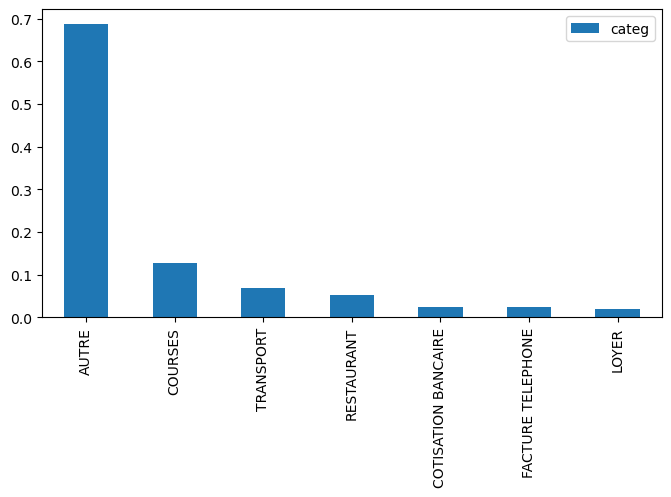

In [285]:
df['categ'].value_counts(normalize=True).plot.bar(figsize=(8,4), legend=True)

<AxesSubplot:ylabel='categ'>

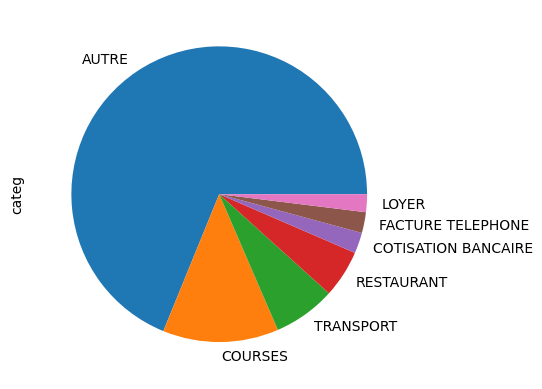

In [286]:
df['categ'].value_counts(normalize=True).plot.pie()

In [287]:
df['quartile_date'] = np.int8((df['date_operation'].dt.day - 1 )/ 31 * 4) + 1

<AxesSubplot:>

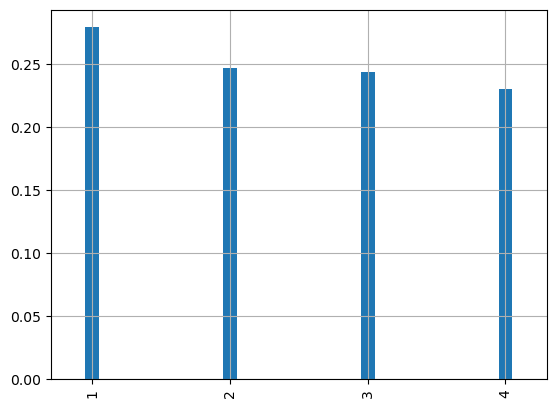

In [288]:
df['quartile_date'].value_counts(normalize=True).plot.bar(width=0.1, grid=True)

<AxesSubplot:>

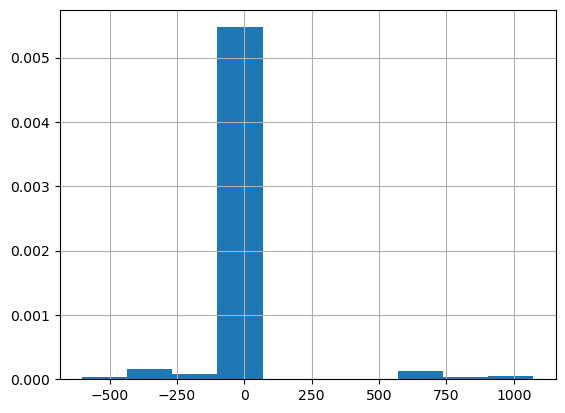

In [289]:
df["montant"].hist(density=True)

<AxesSubplot:>

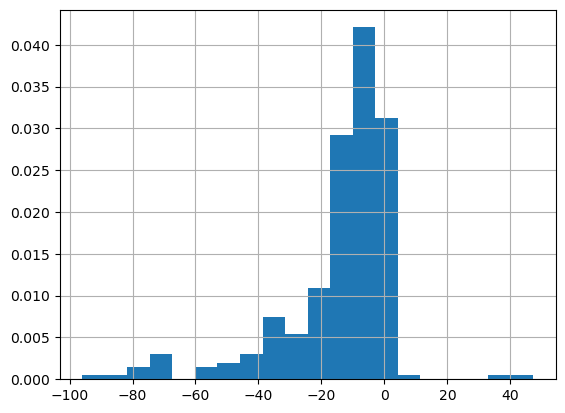

In [290]:
df.loc[df.montant.abs() < 100, 'montant'].hist(density=True,bins=20)

## 7. Représentation en tableau

In [291]:
quartile_data_tabs = pd.DataFrame()
quartile_data_tabs['quartile'] = df['quartile_date'].value_counts().index
quartile_data_tabs['effectif'] = df['quartile_date'].value_counts().values

In [292]:
quartile_data_tabs.head()

,quartile,effectif
0,1,86
1,2,76
2,3,75
3,4,71


In [293]:
quartile_data_tabs['frequence'] = quartile_data_tabs['effectif'] / len(df)
quartile_data_tabs.head()

,quartile,effectif,frequence
0,1,86,0.279221
1,2,76,0.246753
2,3,75,0.243506
3,4,71,0.230519


In [294]:
quartile_data_tabs.sort_values('quartile', inplace=True)
quartile_data_tabs['frequence_cumule'] = quartile_data_tabs['frequence'].cumsum()
quartile_data_tabs.head()

,quartile,effectif,frequence,frequence_cumule
0,1,86,0.279221,0.279221
1,2,76,0.246753,0.525974
2,3,75,0.243506,0.769481
3,4,71,0.230519,1.000000


## 8. Stats

In [295]:
df['montant'].mode()

0   -1.6
Name: montant, dtype: float64

In [296]:
df['montant'].mean()

2.8725649350649407

In [297]:
df['montant'].median()

-9.6

In [298]:
df.groupby('categ')['montant'].agg(['mean', 'median'])

,mean,median
categ,,
AUTRE,23.433208,-8.31
COTISATION BANCAIRE,-1.885714,-1.92
COURSES,-16.341282,-12.24
FACTURE TELEPHONE,-12.045714,-7.02
LOYER,-345.000000,-345.00
RESTAURANT,-10.332500,-10.10
TRANSPORT,-52.997143,-53.10


--------------------
AUTRE
Moyenne: 23.433207547169836
Medianne: 23.433207547169836
Mode: 0   -1.6
Name: montant, dtype: float64
Variance: 40593.3078598051
Variance corrigée: 40401.82999254187
Ecart type: 201.47780984467025
Skewness: 3.1215325222336423
Kurtosis: 12.716537970826295


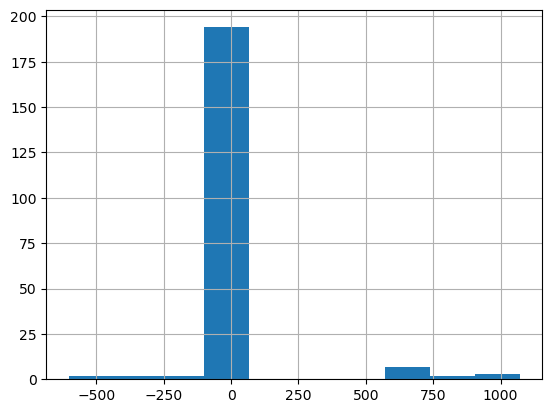

--------------------
TRANSPORT
Moyenne: -52.99714285714286
Medianne: -52.99714285714286
Mode: 0   -73.0
Name: montant, dtype: float64
Variance: 2315.267711428572
Variance corrigée: 2205.016868027212
Ecart type: 48.11722884194987
Skewness: -1.248265076217821
Kurtosis: 2.1922705326917495


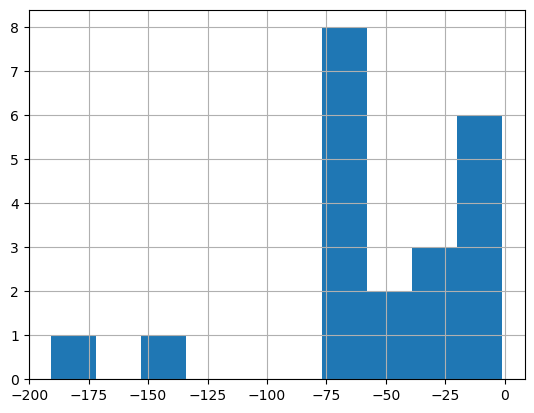

--------------------
FACTURE TELEPHONE
Moyenne: -12.045714285714283
Medianne: -12.045714285714283
Mode: 0   -7.02
1   -6.38
Name: montant, dtype: float64
Variance: 122.52222857142853
Variance corrigée: 105.01905306122445
Ecart type: 11.068975949537
Skewness: -2.3876514564281526
Kurtosis: 5.798563367885492


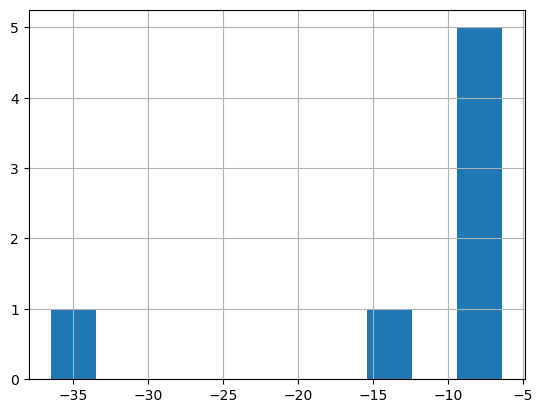

--------------------
COURSES
Moyenne: -16.341282051282054
Medianne: -16.341282051282054
Mode: 0    -60.16
1    -42.45
2    -42.42
3    -33.55
4    -32.67
5    -29.18
6    -28.11
7    -27.68
8    -26.58
9    -26.19
10   -23.43
11   -22.59
12   -21.73
13   -20.59
14   -18.45
15   -17.16
16   -13.59
17   -12.96
18   -12.49
19   -12.24
20   -10.91
21   -10.36
22    -9.88
23    -9.60
24    -9.31
25    -9.11
26    -6.89
27    -6.80
28    -6.60
29    -5.88
30    -4.63
31    -4.41
32    -4.39
33    -3.48
34    -2.93
35    -2.56
36    -2.51
37    -1.90
38    -0.94
Name: montant, dtype: float64
Variance: 181.68391673414305
Variance corrigée: 177.0253547666009
Ecart type: 13.479017647222777
Skewness: -1.2467488306456977
Kurtosis: 1.604730494087499


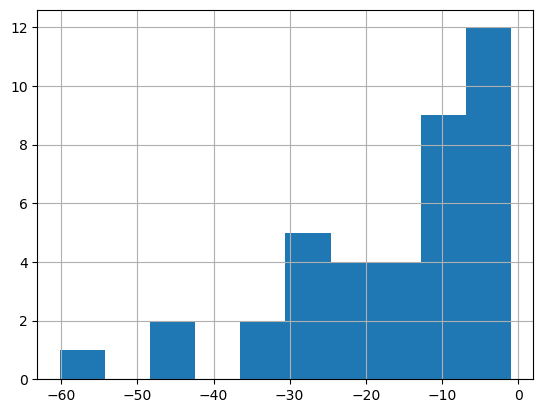

--------------------
COTISATION BANCAIRE
Moyenne: -1.8857142857142857
Medianne: -1.8857142857142857
Mode: 0   -1.92
Name: montant, dtype: float64
Variance: 0.0018285714285714218
Variance corrigée: 0.0015673469387755044
Ecart type: 0.04276179870598782
Skewness: 0.37416573867739106
Kurtosis: -2.800000000000003


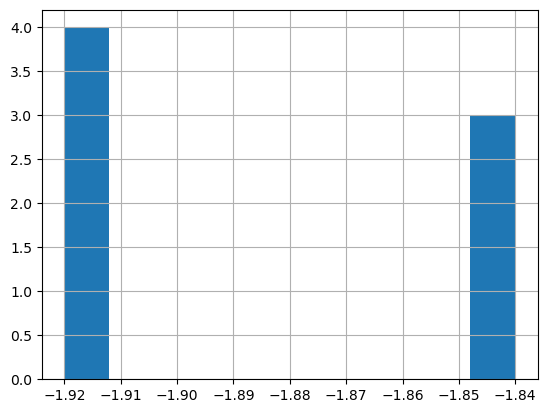

--------------------
RESTAURANT
Moyenne: -10.332500000000001
Medianne: -10.332500000000001
Mode: 0   -9.2
Name: montant, dtype: float64
Variance: 3.0434066666666677
Variance corrigée: 2.853193750000001
Ecart type: 1.7445362325462512
Skewness: -0.8883503487158837
Kurtosis: 0.5988855591691937


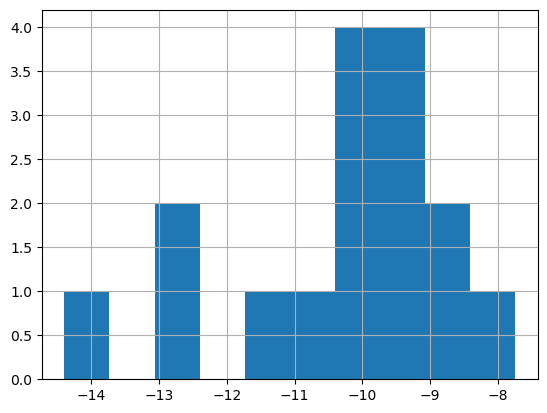

--------------------
LOYER
Moyenne: -345.0
Medianne: -345.0
Mode: 0   -345.0
Name: montant, dtype: float64
Variance: 0.0
Variance corrigée: 0.0
Ecart type: 0.0
Skewness: 0
Kurtosis: 0


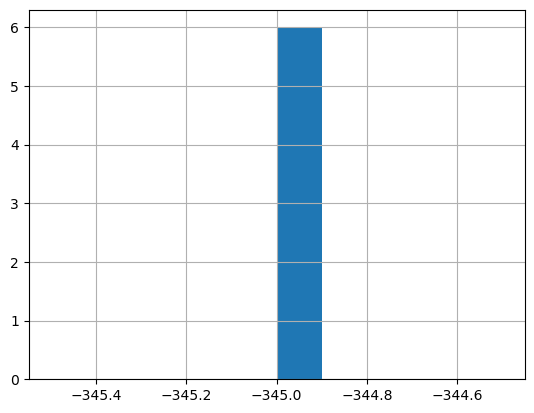

In [299]:
import matplotlib.pyplot as plt
for category in df['categ'].unique():
    print('-'*20)
    print(category)
    subset = df.loc[df['categ']==category, :]
    mean = subset['montant'].mean()
    median = subset['montant'].mean()
    mode = subset['montant'].mode()
    variance = subset['montant'].var()
    varianceCorrige = subset['montant'].var(ddof=0)
    ecartType = subset['montant'].std()
    skewness = subset['montant'].skew()
    kurtosis = subset['montant'].kurtosis()
    print(f'Moyenne: {mean}')
    print(f'Medianne: {median}')
    print(f'Mode: {mode}')
    print(f'Variance: {variance}')
    print(f'Variance corrigée: {varianceCorrige}')
    print(f'Ecart type: {ecartType}')
    print(f'Skewness: {skewness}')
    print(f'Kurtosis: {kurtosis}')
    subset['montant'].hist()
    plt.show()

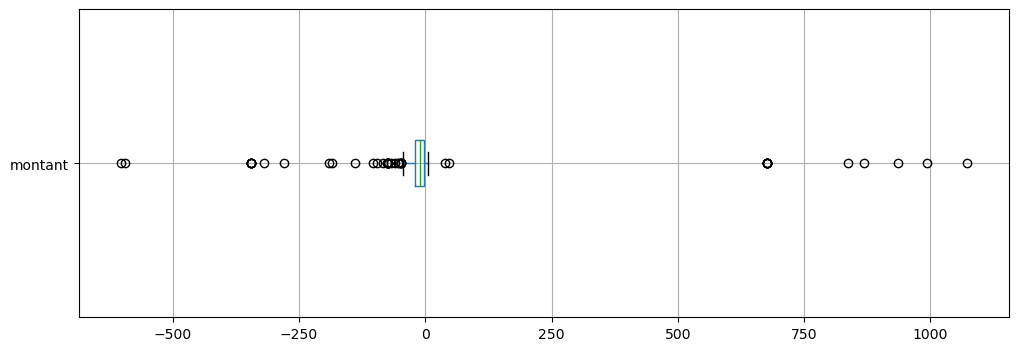

In [300]:
df.boxplot(column="montant", vert=False, figsize=(12,4))
plt.show()

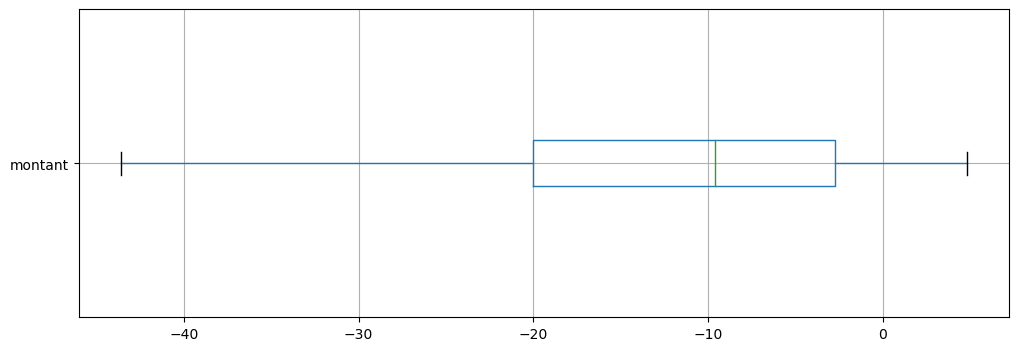

In [301]:
df.boxplot(column="montant", vert=False, figsize=(12,4), showfliers=False)
plt.show()

## Lorenz

291
-0.003436426116838488
1.0034364261168385


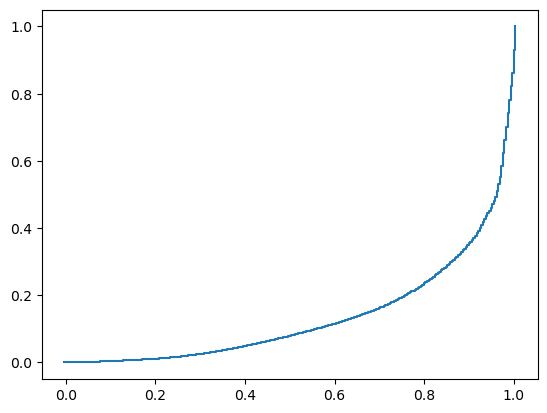

In [302]:
depenses = df[df['montant'] < 0]
dep = -depenses['montant'].values
n = len(dep)
print(n)
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0
print(0-1/n)
print(1+1/n)
xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.show()

In [303]:
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
gini

0.7204386813739185

## Analyse bivariée

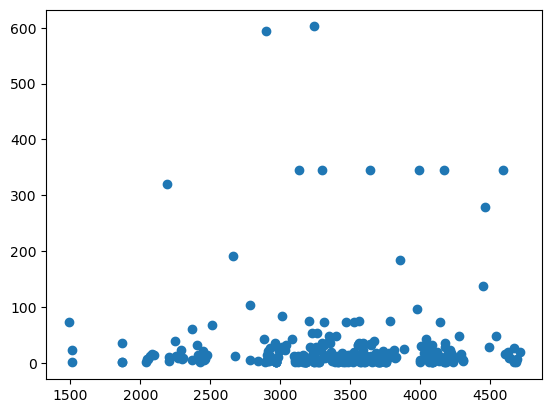

In [304]:
plt.scatter(df.loc[df['montant'] < 0, 'solde_avt_ope'], -df.loc[df['montant'] < 0, 'montant'])
plt.show()

In [305]:
df.head()

,date_operation,libelle,montant,solde_avt_ope,categ,quartile_date
0,2023-03-31,DON XX XX XX XX XX XX XX,-1.44,1515.25,AUTRE,4
1,2023-04-03,CARTE XX XX RAPT XX,-24.00,1513.81,TRANSPORT,1
2,2023-04-03,CARTE XX XX RAPT XX,-73.00,1489.81,TRANSPORT,1
3,2023-04-03,VIREMENT XX XX XX XX XX XX XX XX XX XX XX XX,676.00,1416.81,AUTRE,1
4,2023-04-03,VIREMENT XX XX XX XX XX XX,4.80,2092.81,AUTRE,1


In [363]:
df_depenses = df.loc[df['montant'] < 0].copy()
df_depenses['montant'] = -df_depenses['montant']

In [364]:
# df['category']=pd.cut(x=df['age'], bins=[0,14,24,64,100],labels=category)
bins_min = df_depenses['solde_avt_ope'].min()
bins_max = df_depenses['solde_avt_ope'].max()
print(bins_min, bins_max)

1489.81 4709.31


In [365]:
bins = np.arange(1250,5000, 500)
bins

array([1250, 1750, 2250, 2750, 3250, 3750, 4250, 4750])

In [366]:
labels=[1500,2000,2500,3000,3500,4000,4500]

In [367]:
df_depenses['sold_group'] = pd.cut(df_depenses['solde_avt_ope'], bins, labels=labels)

In [368]:
df_depenses.head()

,date_operation,libelle,montant,solde_avt_ope,categ,quartile_date,sold_group
0,2023-03-31,DON XX XX XX XX XX XX XX,1.44,1515.25,AUTRE,4,1500
1,2023-04-03,CARTE XX XX RAPT XX,24.00,1513.81,TRANSPORT,1,1500
2,2023-04-03,CARTE XX XX RAPT XX,73.00,1489.81,TRANSPORT,1,1500
5,2023-04-03,CARTE XX XX XX XX,14.39,2097.61,AUTRE,1,2000
6,2023-04-05,CARTE XX XX XX XX XX,15.20,2083.22,AUTRE,1,2000


In [369]:
labels

[1500, 2000, 2500, 3000, 3500, 4000, 4500]

In [370]:
np.zeros(len(labels))

array([0., 0., 0., 0., 0., 0., 0.])

In [371]:
df_depenses['sold_group'].value_counts()[3000]

66

1500 3
2000 13
2500 23
3000 66
3500 105
4000 60
4500 21


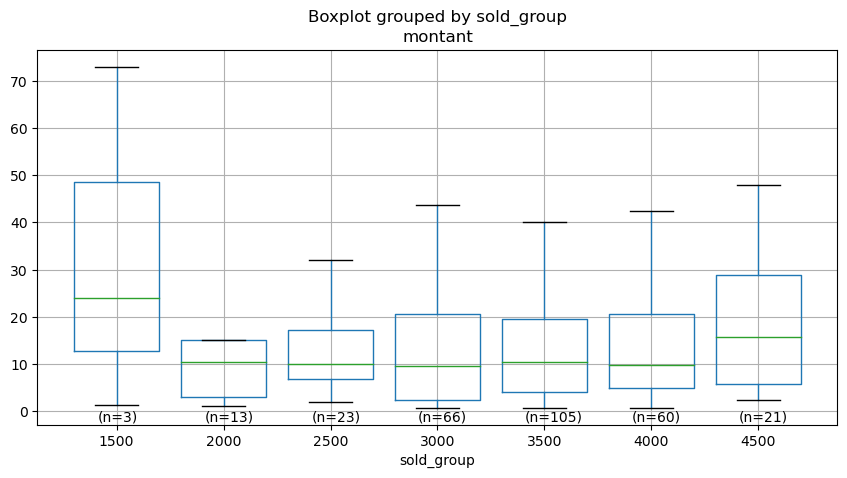

In [388]:
df_depenses.boxplot(column='montant', by='sold_group', figsize=(10,5), showfliers=False, positions=labels, widths=400)
for label in labels:
    print(label, df_depenses['sold_group'].value_counts()[label])
    n = df_depenses['sold_group'].value_counts()[label]
    plt.text(label-90, -2, f'(n={n})')
plt.show()

In [389]:
import scipy.stats as st

In [392]:
st.pearsonr(df_depenses['solde_avt_ope'], df_depenses['montant'])

PearsonRResult(statistic=0.010068819133759187, pvalue=0.864203121377216)

In [394]:
np.cov(df_depenses['solde_avt_ope'], df_depenses['montant'], ddof=0)

array([[422791.93532421,    484.95954155],
       [   484.95954155,   5486.90249853]])